In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt 
import jax.numpy as jnp
from jax import random
from numpyro.infer import Predictive
from reusable.util import load_samples, gen_file_name, get_decoder_params, load_args, load_training_state, save_samples
from reusable.gp import BuildGP
from reusable.mcmc import vae_mcmc, run_mcmc
from reusable.geo import get_temp_data
from plotting.plots import plot_draws, compare_draws, plot_one_inference
from plotting.ny import plot_multi_on_state, plot_on_state, mask_for_plotting
import numpyro

numpyro.set_host_device_count(4)


In [2]:
args = load_args(19, 1, 1)
rng_key = random.PRNGKey(3)
if "n" not in args:
    args["n"] = args["x"].shape[0]

    
rng_key, rng_key_init, rng_key_init_state, rng_key_plots = random.split(rng_key, 4)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
args["scoring_num_draws"] = 1000

## Comparing GP to PriorVAE draws

In [4]:
should_load_samples = True
to_plot = 200

if should_load_samples:
    gp_plot_samples = load_samples(19, f"gp_plot_{to_plot}")
else:
    
    gp = BuildGP(
            args["gp_kernel"],
            noise=False,
            length_prior_choice=args["length_prior_choice"],
            prior_args=args["length_prior_arguments"],
        )

    print("Starting GP")

    gp_plot_pred = Predictive(gp, num_samples=to_plot)
    gp_plot_samples = gp_plot_pred(rng_key_plots, args["x"], jitter=5e-5)

    print("Done GP")
    save_samples(19,f"gp_plot_{to_plot}", gp_plot_samples)

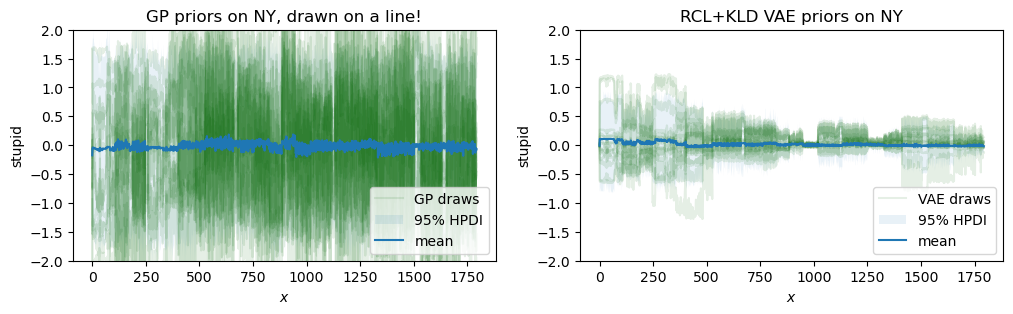

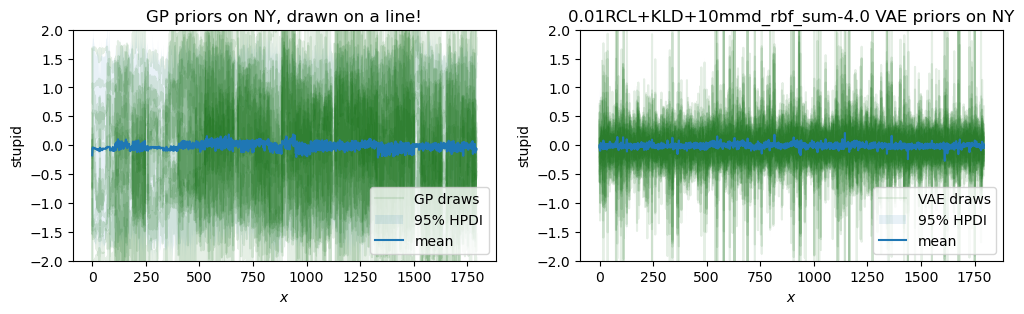

In [5]:
from plotting.plots import compare_draws
from reusable.vae import VAE
import optax
from reusable.train_nn import SimpleTrainState

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["x"].shape[0],
    conditional=True,
)
params = module.init(rng_key_init, jnp.ones((args["batch_size"], args["n"],)))[
    "params"
]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
dummy_state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init_state)

samples = {}

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    file_name = gen_file_name(args["expcode"], args, loss_fn)

    decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))   

    vae=vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=None,
            noise=False,
        )

    

    cvae_plot_pred = Predictive(vae, num_samples=to_plot)
    samples[loss_fn] = cvae_plot_pred(rng_key_plots, args["x"], jitter=5e-5)
    compare_draws(
        jnp.arange(0, args["x"].shape[0]),
        gp_plot_samples["y"],
        samples[loss_fn]["f"],
        "GP priors on NY, drawn on a line!",
        f"{loss_fn} VAE priors on NY",
        "stupid",
        "stupid",
        "GP",
        "VAE"
    )


(8, 1794)
(8, 1794)


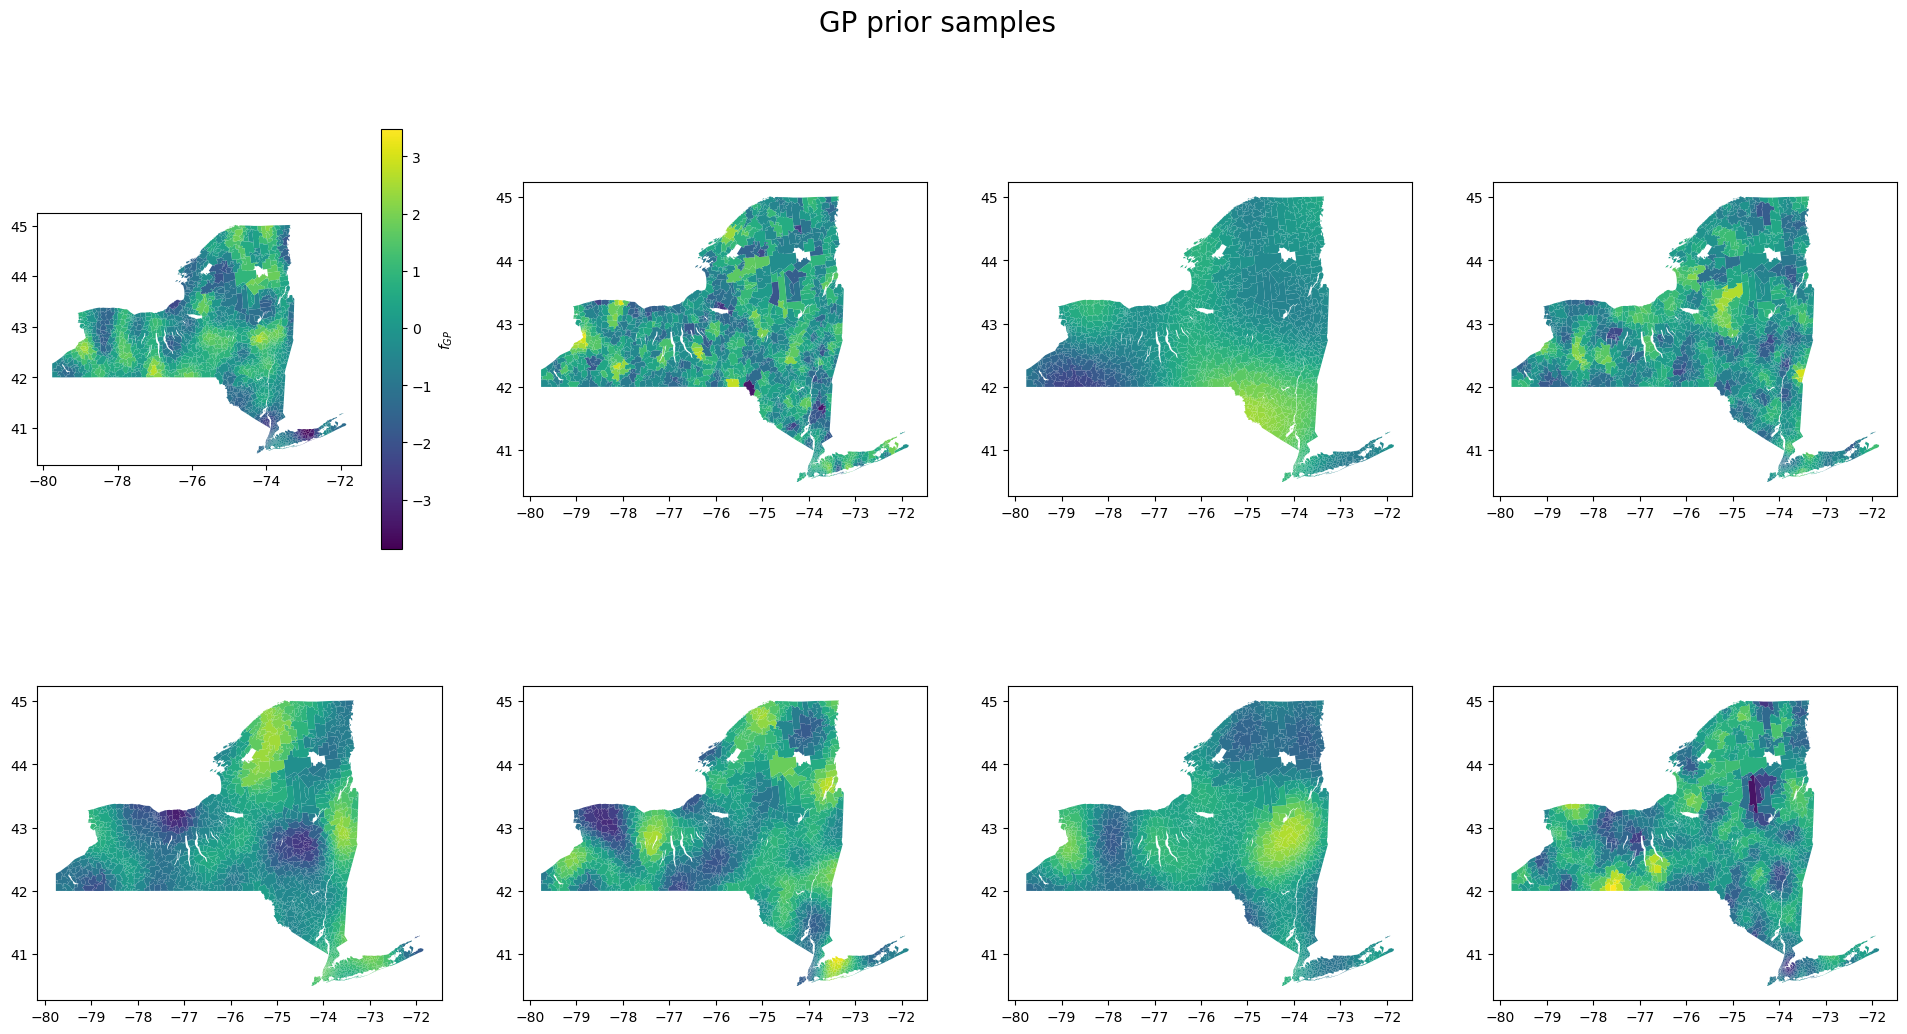

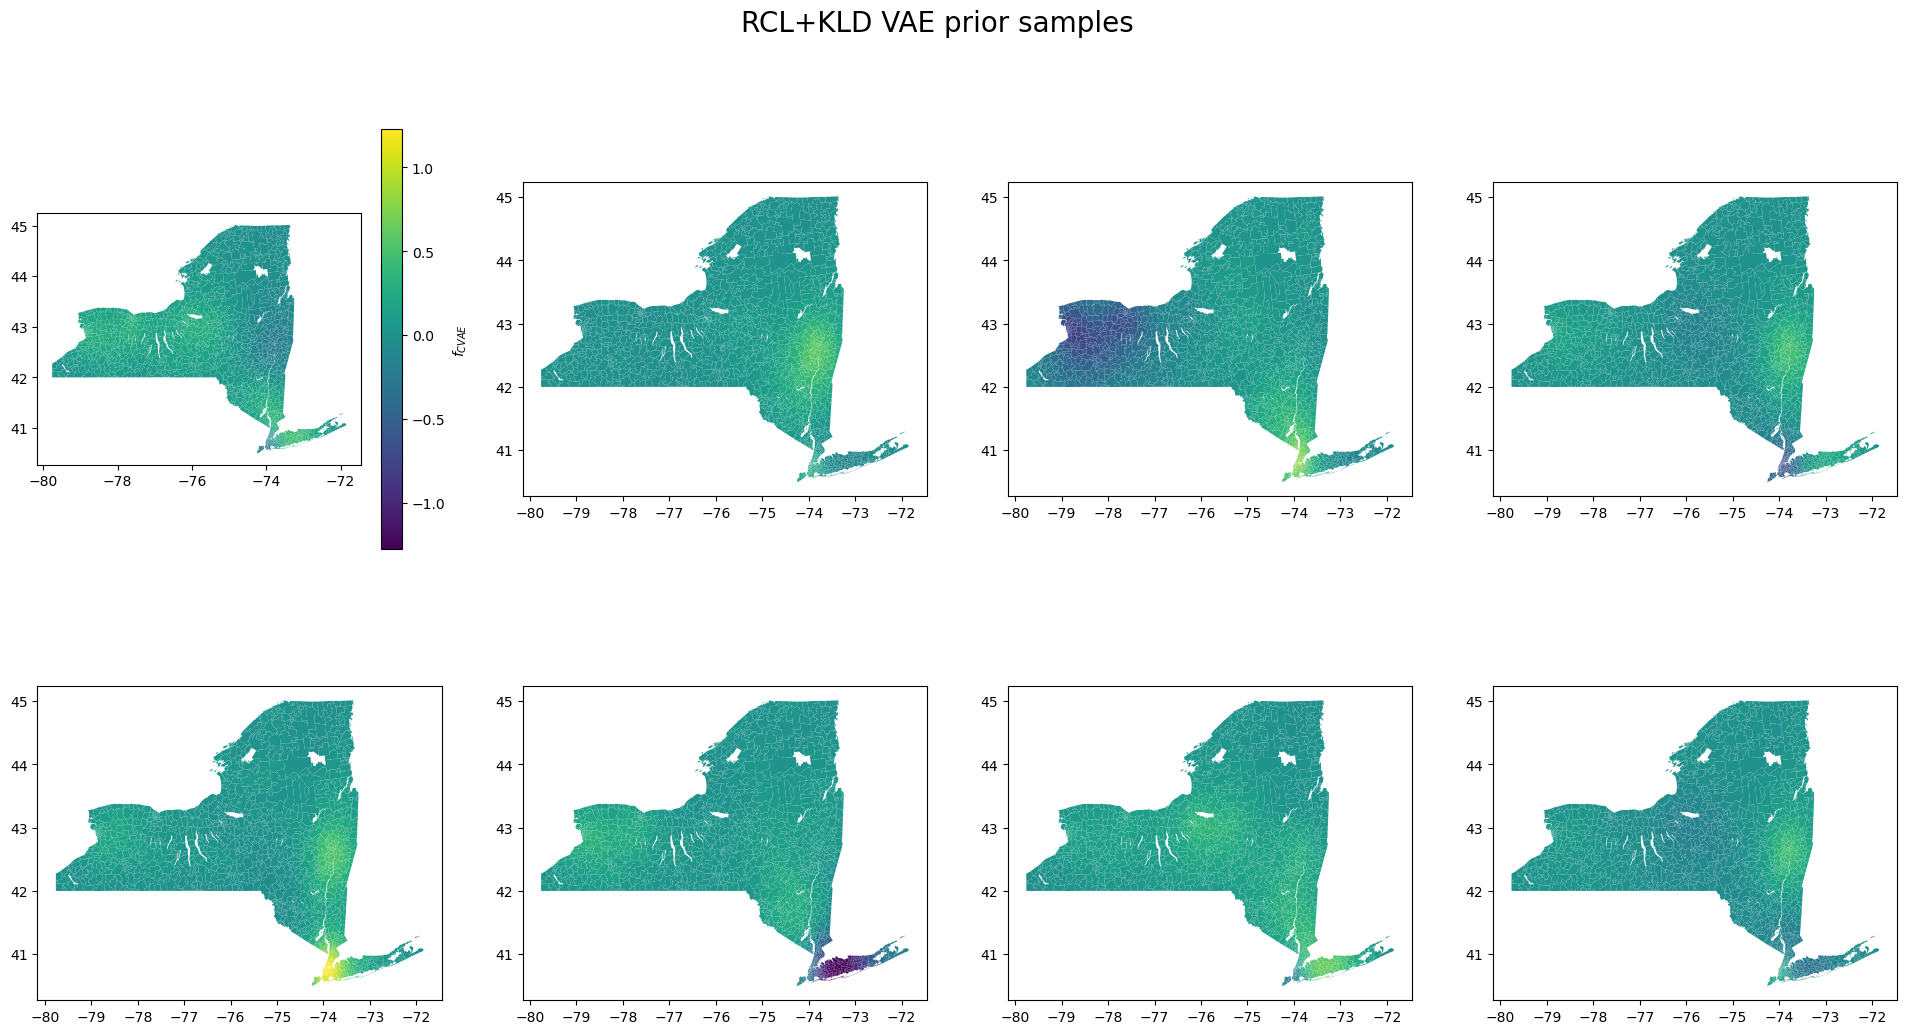

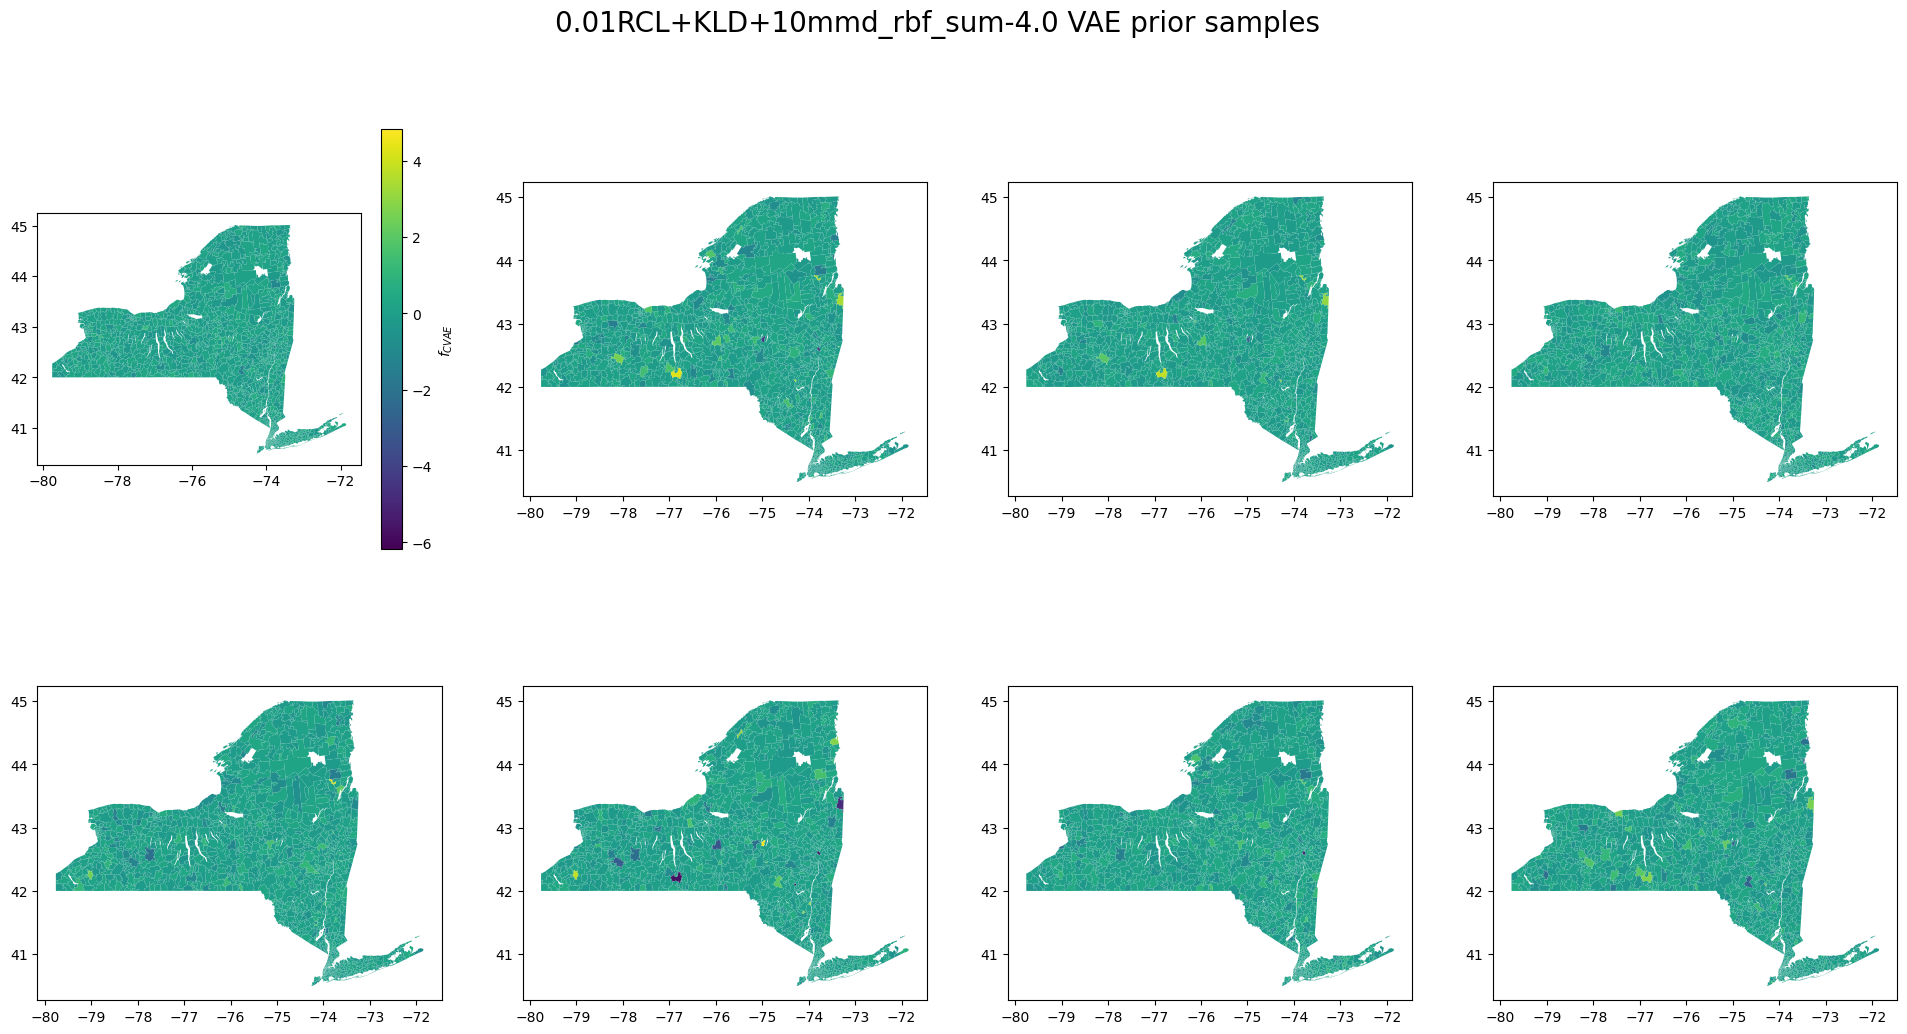

In [6]:
plot_multi_on_state(gp_plot_samples["y"][:8], args["state"], "GP prior samples", "$f_{GP}$")

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    print(samples[loss_fn]["f"][:8].shape)
    plot_multi_on_state(samples[loss_fn]["f"][:8], args["state"], f"{loss_fn} VAE prior samples", "$f_{CVAE}$")


### Ground truth

In [7]:
ground_truth = get_temp_data(args["state"], args["year"], args["aggr_method"])["tmean"].to_numpy() / 100

print(ground_truth)

plot_on_state(ground_truth, args["state"], "Ground truth", "HIV cases")

[0.29374929 0.33524719 0.32945292 ... 0.26635826 0.27059303 0.26868236]


## Masked ground truth

In [8]:
rng_key_ground_truth_obs_mask = random.PRNGKey(4)


num_obs = int(args["n"] * 0.5)
print(args["n"], num_obs)

obs_mask = jnp.concatenate((jnp.full((num_obs), True), jnp.full((args["n"]-num_obs), False)))
print(obs_mask.shape, obs_mask)
obs_mask = random.permutation(rng_key_ground_truth_obs_mask, obs_mask)
print(obs_mask)

obs_idx = [x for x in range(args["n"]) if obs_mask[x]==True]
print(len(obs_idx))
obs_idx = jnp.array(obs_idx)

print(obs_mask.sum())

ground_truth_y_obs = ground_truth[obs_idx]
x_obs = jnp.arange(0, args["n"])[obs_idx]

plot_on_state(mask_for_plotting(ground_truth, obs_idx), args["state"], "Masked ground truth", "GT")


1794 897
(1794,) [ True  True  True ... False False False]
[ True False False ...  True False  True]
897
897


### Inference

In [9]:
vaes = {}


for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    gen_file_name(args["expcode"], args, "gp" if loss_fn is None else loss_fn)
    decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))

    vaes[loss_fn] = vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=obs_idx,
            noise=True,
        )

In [10]:
rng_key = random.PRNGKey(2345678)


mcmc_samples = {}

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    
    

    label = f"{loss_fn}"


    rng_key, rng_key_mcmc = random.split(rng_key, 2)

    mcmc_samples[loss_fn] = run_mcmc(
        args["num_warmup"],
        4000, #args["num_samples"],
        args["num_chains"],
        rng_key_mcmc,
        vaes[loss_fn],
        {"x": args["x"],
         "y": ground_truth_y_obs},
        verbose=True,
        max_run_length=None
    )

    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC warmup run 1/1


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Done MCMC run 1/1

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.02      0.03     -0.02     -0.06      0.03  16147.72      1.00
      f[1]      0.08      0.04      0.08      0.01      0.14  16150.82      1.00
      f[2]      0.01      0.05      0.01     -0.07      0.09  16951.51      1.00
      f[3]      0.13      0.06      0.13      0.04      0.22  15160.39      1.00
      f[4]     -0.01      0.02     -0.01     -0.04      0.02  17848.89      1.00
      f[5]     -0.00      0.02     -0.00     -0.03      0.02  16796.15      1.00
      f[6]     -0.05      0.02     -0.05     -0.09     -0.02  16190.74      1.00
      f[7]      0.06      0.03      0.06      0.02      0.11  17155.27      1.00
      f[8]      0.01      0.02      0.01     -0.02      0.04  16180.07      1.00
      f[9]     -0.01      0.04     -0.01     -0.07      0.05  16511.36      1.00
     f[10]      0.00      0.03      0.00     -0.04      0.05  16955.25      1.00
     f[11

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC warmup run 1/1


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Done MCMC run 1/1

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.02      0.03     -0.02     -0.06      0.03  16065.73      1.00
      f[1]      0.08      0.04      0.08      0.01      0.14  17128.03      1.00
      f[2]      0.01      0.05      0.01     -0.07      0.09  17024.96      1.00
      f[3]      0.13      0.06      0.13      0.03      0.22  16034.44      1.00
      f[4]     -0.01      0.02     -0.01     -0.04      0.02  16843.00      1.00
      f[5]     -0.00      0.02     -0.00     -0.03      0.02  17048.90      1.00
      f[6]     -0.05      0.02     -0.05     -0.09     -0.02  16982.77      1.00
      f[7]      0.06      0.03      0.06      0.01      0.10  18353.29      1.00
      f[8]      0.01      0.02      0.01     -0.02      0.04  15170.43      1.00
      f[9]     -0.01      0.04     -0.01     -0.07      0.05  16400.20      1.00
     f[10]      0.00      0.03      0.00     -0.04      0.05  16994.14      1.00
     f[11

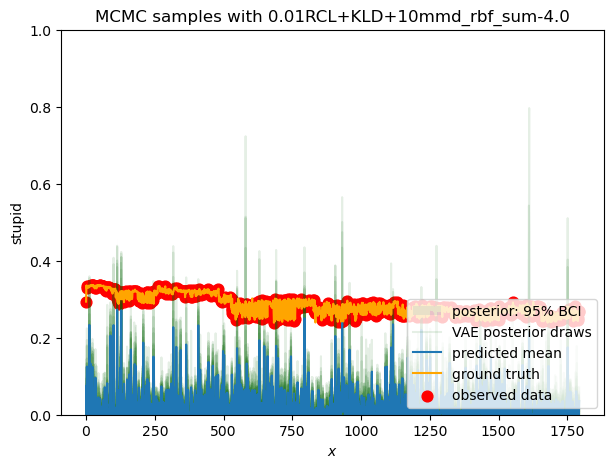

In [17]:

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    plot_one_inference(
        mcmc_samples[loss_fn]["f"],
        jnp.arange(0, args["x"].shape[0]),
        ground_truth,
        x_obs,
        ground_truth_y_obs,
        f"MCMC samples with {loss_fn}",
        "stupid",
        "VAE",
        _min=0,
        _max=1,
    )



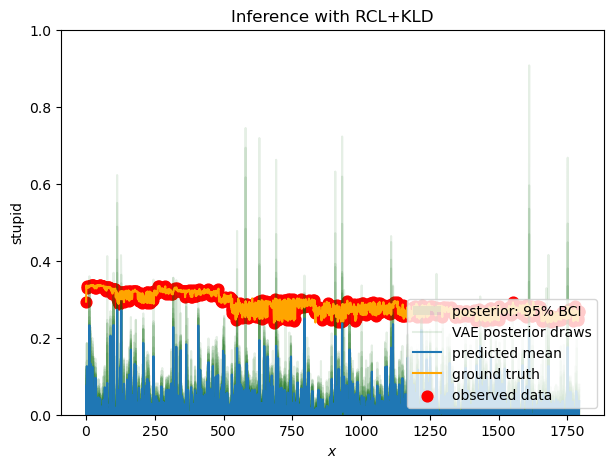

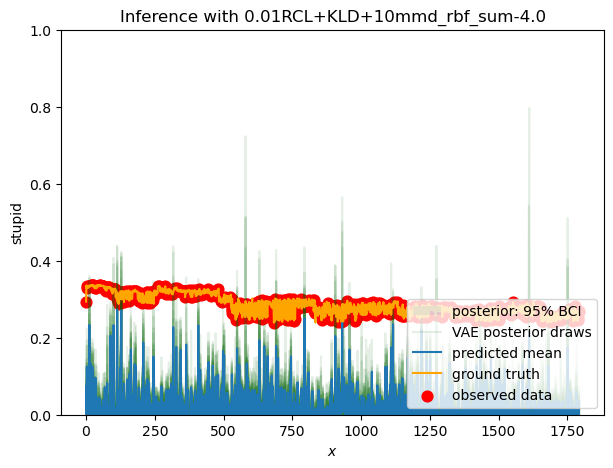

In [18]:
rng_key, rng_key_pred = random.split(rng_key, 2)
for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    predictive = Predictive(vaes[loss_fn], mcmc_samples[loss_fn])
    predictions = predictive(rng_key_pred, args["x"], y=ground_truth)

    plot_one_inference(
        predictions["f"],
        jnp.arange(0, args["x"].shape[0]),
        ground_truth,
        x_obs,
        ground_truth_y_obs,
        f"Inference with {loss_fn}",
        "stupid",
        "VAE",
        _min=0,
        _max=1,
    )
